### 시계열 데이터를 Box-Jenkins ARIMA Procedure을 활용하여 미래시점에 대해 예측해보고 예측 성능 평가까지 수행

# 1. Import Modules

In [1]:
import os

import pandas as pd
import pandas_datareader.data as pdr # pip install pandas_datareader

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
# sns.set_style('white')

import itertools

# 2. Load Data

In [2]:
# 2월15일 ~ 12월7일까지 코로나 일일 확진자수

data = pd.read_csv('./Number_of_confirmed_patients(Daily).csv')
data = data.loc[:, ['statedt', 'decidecnt_day']]
data = data.rename(columns={'statedt':'date', 'decidecnt_day':'decidecnt'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

print(data.info())
display(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 297 entries, 2020-02-15 to 2020-12-07
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   decidecnt  297 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB
None


,decidecnt
date,
2020-02-15,1
2020-02-16,1
2020-02-17,1
2020-02-18,20
2020-02-19,53
...,...
2020-12-03,629
2020-12-04,583
2020-12-05,631


# 3. Box-Jenkins ARIMA Procedure
- 3.1 Data Preprocessing
- 3.2 Identify Model to be Tentatively Entertainted (개략적 모델 구축)
- 3.3 Estimate Parameters (파라미터 탐색)
- 3.4 Diagnosis Check (후보 모델 진단)
- 3.5 Use Model to Forecast

## 3.1 Data Preprocessing

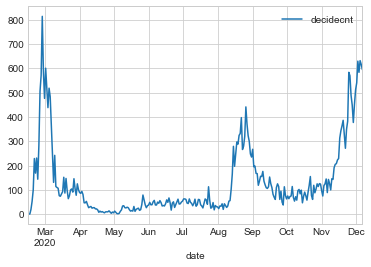

In [3]:
# Raw data plot
fig = data.plot() # 데이터 특성파악

## 3.2 Identify Model to be Tentatively Entertainted

In [4]:
train_data = data.copy()

In [5]:
timestamp = pd.date_range(start='2020-12-08', end=None, periods=83, freq='D')
timestamp_list = list(map(str, list(timestamp)))
print(timestamp_list)

['2020-12-08 00:00:00', '2020-12-09 00:00:00', '2020-12-10 00:00:00', '2020-12-11 00:00:00', '2020-12-12 00:00:00', '2020-12-13 00:00:00', '2020-12-14 00:00:00', '2020-12-15 00:00:00', '2020-12-16 00:00:00', '2020-12-17 00:00:00', '2020-12-18 00:00:00', '2020-12-19 00:00:00', '2020-12-20 00:00:00', '2020-12-21 00:00:00', '2020-12-22 00:00:00', '2020-12-23 00:00:00', '2020-12-24 00:00:00', '2020-12-25 00:00:00', '2020-12-26 00:00:00', '2020-12-27 00:00:00', '2020-12-28 00:00:00', '2020-12-29 00:00:00', '2020-12-30 00:00:00', '2020-12-31 00:00:00', '2021-01-01 00:00:00', '2021-01-02 00:00:00', '2021-01-03 00:00:00', '2021-01-04 00:00:00', '2021-01-05 00:00:00', '2021-01-06 00:00:00', '2021-01-07 00:00:00', '2021-01-08 00:00:00', '2021-01-09 00:00:00', '2021-01-10 00:00:00', '2021-01-11 00:00:00', '2021-01-12 00:00:00', '2021-01-13 00:00:00', '2021-01-14 00:00:00', '2021-01-15 00:00:00', '2021-01-16 00:00:00', '2021-01-17 00:00:00', '2021-01-18 00:00:00', '2021-01-19 00:00:00', '2021-01-2

In [6]:
# 최근 2주 평균확진자 수

# mean_2weeks = int(train_data.iloc[-14:,:].mean())
# print(mean_2weeks)
# print('---------------------------------------------------')

test_data_dict = {'date':timestamp_list, 'decidecnt':[0 for x in range(83)]}
test_data = pd.DataFrame(test_data_dict)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

print(test_data.info())
display(test_data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2020-12-08 to 2021-02-28
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   decidecnt  83 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB
None


,decidecnt
date,
2020-12-08,0
2020-12-09,0
2020-12-10,0
2020-12-11,0
2020-12-12,0
...,...
2021-02-24,0
2021-02-25,0
2021-02-26,0


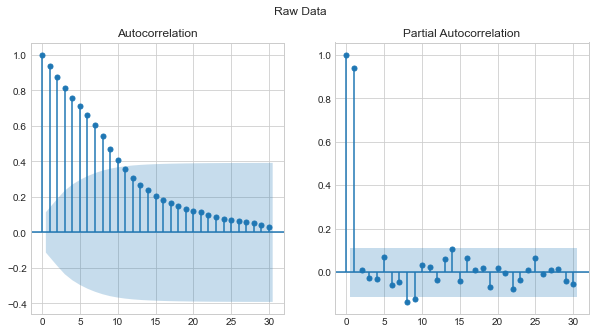

In [7]:
# ACF, PACF plot

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax  = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0]) # Non-Stationary
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); # ; Modify not to generate graph twice

### Differencing (차분)
- If original series is non-stationary, differencing might be needed.
- 차분 : 현 시점 데이터에서 d 시점 이전 데이터를 뺀 것.

![제목 없음](https://user-images.githubusercontent.com/64063767/101566598-99daae80-3a12-11eb-8521-bdfe4bcffb20.png)

In [8]:
# Differencing (1차 차분)

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['decidecnt'].diff(1)
diff_train_data = diff_train_data.dropna() # 결측치 제거 (차분을 하게되면 길이가 안맞아서 결측치로 들어가게되되는데, 이는 예측에 부정적영향을 줄 수 있으므로 제거한다)

print('####### Raw Data #######')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

####### Raw Data #######
            decidecnt
date                 
2020-02-15          1
2020-02-16          1
2020-02-17          1
2020-02-18         20
2020-02-19         53
...               ...
2020-12-03        629
2020-12-04        583
2020-12-05        631
2020-12-06        615
2020-12-07        594

[297 rows x 1 columns]
### Differenced Data ###
date
2020-02-16     0.0
2020-02-17     0.0
2020-02-18    19.0
2020-02-19    33.0
2020-02-20    47.0
              ... 
2020-12-03    89.0
2020-12-04   -46.0
2020-12-05    48.0
2020-12-06   -16.0
2020-12-07   -21.0
Name: decidecnt, Length: 296, dtype: float64


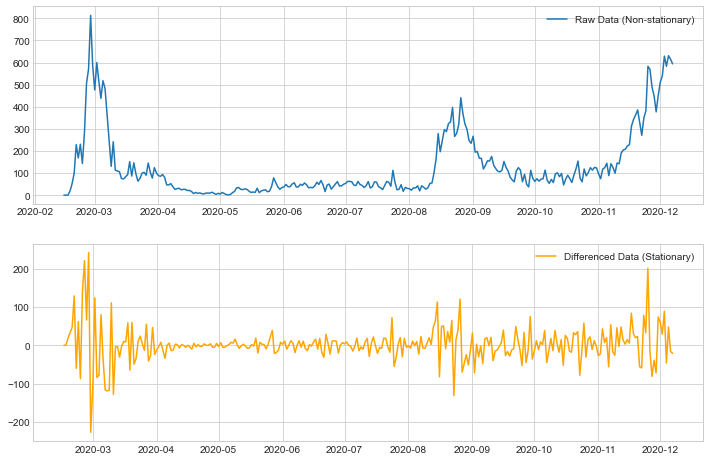

In [9]:
# Differenced data plot

plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(train_data['decidecnt'])
plt.legend(['Raw Data (Non-stationary)'])

plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference; t - (t-1)
plt.legend(['Differenced Data (Stationary)'])

plt.show()

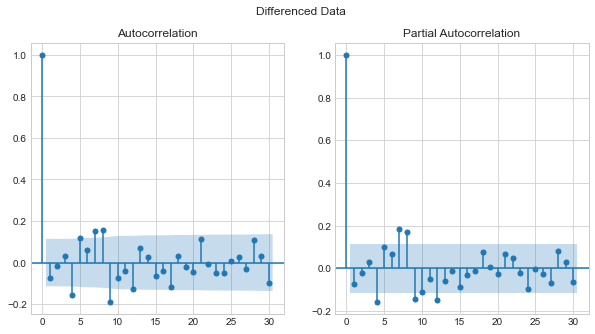

In [10]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); # ; Modify not to generate graph twice

## 3.3 Estimate Parameters

In [12]:
# ARIMA 모수는 통상적으로 p+q < 2, p*q = 0의 값들을 많이 사용한다.
# 어떤식으로 모델을 선정할지는 rules of thumb... 여기서는 p=1, d=1, q=0 으로 ARIMA(1,1,0) 모델을 선정해본다.

# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

import warnings
warnings.filterwarnings('ignore')

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  296
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1556.459
Method:                       css-mle   S.D. of innovations             46.496
Date:                Sat, 12 Dec 2020   AIC                           3118.919
Time:                        09:40:51   BIC                           3129.990
Sample:                             1   HQIC                          3123.351
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0093      2.517      0.798      0.425      -2.924       6.942
ar.L1.D.y     -0.0740      0.058     -1.279      0.201      -0.187       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.5101           +0.0000j           13.5101            0.5000
-----------------------------------------------------------------------------
"""

## 3.4.1 Diagnosis Check - ARIMA

In [13]:
# Parameter search

print('Examples of parameter combinations for ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for ARIMA
ARIMA: (0, 1, 0) >> AIC : 3118.55
ARIMA: (0, 1, 1) >> AIC : 3118.85
ARIMA: (0, 1, 2) >> AIC : 3120.75
ARIMA: (1, 1, 0) >> AIC : 3118.92
ARIMA: (1, 1, 1) >> AIC : 3120.74
ARIMA: (1, 1, 2) >> AIC : 3120.1
ARIMA: (2, 1, 0) >> AIC : 3120.75
ARIMA: (2, 1, 1) >> AIC : 3119.55
ARIMA: (2, 1, 2) >> AIC : 3110.22


In [14]:
# 가장 낮은 AIC score의 parameter를 선정한다.

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 3110.22)]

In [15]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
# model_opt = ARIMA(train_data.values, order=(1,1,0))
# model_opt = ARIMA(train_data.values, order=(0,1,1))
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  296
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1549.108
Method:                       css-mle   S.D. of innovations             45.277
Date:                Sat, 12 Dec 2020   AIC                           3110.216
Time:                        09:41:01   BIC                           3132.358
Sample:                             1   HQIC                          3119.081
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1050      2.538      0.829      0.407      -2.869       7.079
ar.L1.D.y     -1.4706      0.032    -45.601      0.000      -1.534      -1.407
ar.L2.D.y     -0.9779      0.029    -33.191      0.000      -1.036      -0.920
ma.L1.D.y      1.4200      0.051     27.856      0.000       1.320       1.520
ma.L2.D.y      0.9052      0.051     17.730      0.000       0.805       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7519           -0.6762j            1.0113           -0.3834
AR.2           -0.7519           +0.6762j            1.0113            0.3834
MA.1           -0.7843           -0.6997j            1.0510           -0.3841
MA.2           -0.7843           +0.6997j            1.0510            0.3841
-----------------------------------------------------------------------------
"""

## 3.5.1 Use Model to Forecast - ARIMA

In [16]:
data_including_future = pd.concat([train_data, test_data], axis=0)

display(data_including_future)

,decidecnt
date,
2020-02-15,1
2020-02-16,1
2020-02-17,1
2020-02-18,20
2020-02-19,53
...,...
2021-02-24,0
2021-02-25,0
2021-02-26,0


In [17]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:, 0]
predicted_lb = prediction[2][:, 1]
predict_index = list(test_data.index)
print(predict_index[0])
r2 = r2_score(test_data, predicted_value)
print('결정계수 R-Squared:', r2)

2020-12-08 00:00:00
결정계수 R-Squared: 0.0


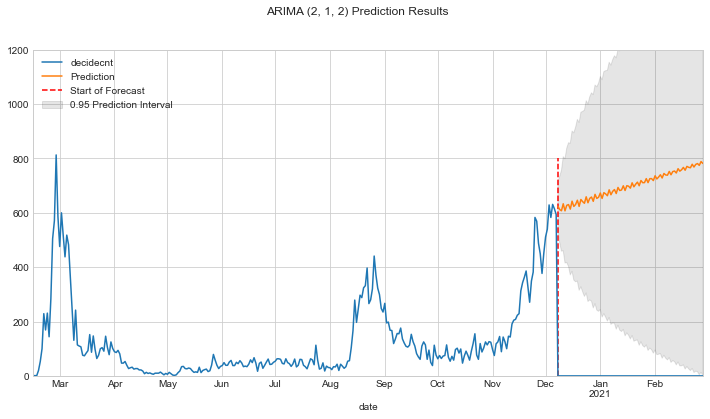

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
data_including_future.plot(ax=ax);
ax.vlines('2020-12-08', 0, 800, linestyle='--', color='r', label='Start of Forecast');
plt.ylim(0,1200)
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results')
plt.savefig('./Forecast Corona Infection Status1(ARIMA).png')
plt.show()

## 3.4.3 Diagnosis Check - auto_arima

In [19]:
# Parameter search

auto_arima_model = auto_arima(train_data, 
                              start_p=1, start_q=1, max_p=3, max_q=3, d=1,
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=nan, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3118.852, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3120.748, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3122.671, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3118.920, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3120.736, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3120.100, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3121.434, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3120.748, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3119.549, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3110.217, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3112.933, Time=0.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3122.501, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3120.191, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3112.116, Time=0.80 sec

Best model:  A

In [21]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  297
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1549.108
Date:                Sat, 12 Dec 2020   AIC                           3110.217
Time:                        09:43:36   BIC                           3132.359
Sample:                             0   HQIC                          3119.082
                                - 297                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.2610      9.182      0.791      0.429     -10.735      25.257
ar.L1         -1.4705      0.032    -46.661      0.000      -1.532      -1.409
ar.L2         -0.9779      0.025    -39.169      0.000      -1.027      -0.929
ma.L1          1.4200      0.056     25.361      0.000       1.310       1.530
ma.L2          0.9053      0.058     15.659      0.000       0.792       1.019
sigma2      2049.9461     94.379     21.720      0.000    1864.967    2234.925
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               480.58
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3.5.3 Use Model to Foreast - auto_arima

In [23]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(test_data.index)
print(predict_index[0])

2020-12-08 00:00:00


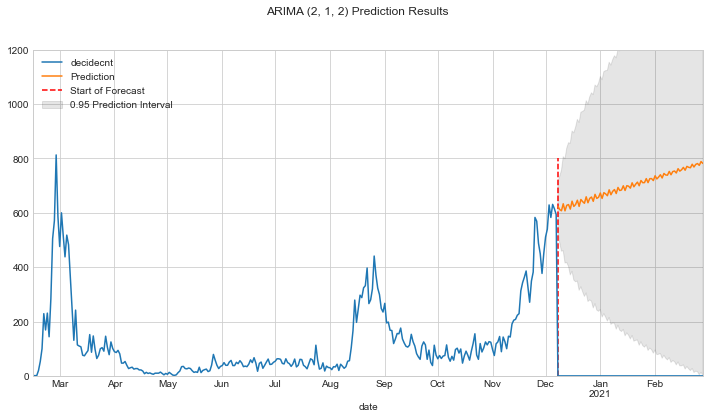

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
data_including_future.plot(ax=ax);
ax.vlines('2020-12-08', 0, 800, linestyle='--', color='r', label='Start of Forecast');
plt.ylim(0,1200)
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order} Prediction Results')
plt.show()

# 최근 1개월 데이터로 시계열 분석

In [25]:
train_data_1month = data.copy()
train_data_1month = train_data_1month.iloc[-30:, :]

display(train_data_1month.head(3))
display(train_data_1month.tail(3))

,decidecnt
date,
2020-11-08,126
2020-11-09,100
2020-11-10,146


,decidecnt
date,
2020-12-05,631
2020-12-06,615
2020-12-07,594


In [28]:
# Parameter search

auto_arima_model = auto_arima(train_data_1month, 
                              start_p=1, start_q=1, max_p=3, max_q=3, d=1,
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=321.791, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=323.772, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=323.772, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=325.772, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=325.753, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=327.580, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=323.656, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit 

In [29]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -158.895
Date:                Sat, 12 Dec 2020   AIC                            321.791
Time:                        09:45:22   BIC                            324.525
Sample:                             0   HQIC                           322.647
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.1379     11.957      1.350      0.177      -7.298      39.574
sigma2      3362.4637    736.777      4.564      0.000    1918.408    4806.520
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.11
Prob(Q):                              0.88   Prob(JB):                         0.05
Heteroskedasticity (H):               3.16   Skew:                             0.82
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# test data

timestamp = pd.date_range(start='2020-12-08', end=None, periods=30, freq='D')
timestamp_list = list(map(str, list(timestamp)))
print(timestamp_list)

['2020-12-08 00:00:00', '2020-12-09 00:00:00', '2020-12-10 00:00:00', '2020-12-11 00:00:00', '2020-12-12 00:00:00', '2020-12-13 00:00:00', '2020-12-14 00:00:00', '2020-12-15 00:00:00', '2020-12-16 00:00:00', '2020-12-17 00:00:00', '2020-12-18 00:00:00', '2020-12-19 00:00:00', '2020-12-20 00:00:00', '2020-12-21 00:00:00', '2020-12-22 00:00:00', '2020-12-23 00:00:00', '2020-12-24 00:00:00', '2020-12-25 00:00:00', '2020-12-26 00:00:00', '2020-12-27 00:00:00', '2020-12-28 00:00:00', '2020-12-29 00:00:00', '2020-12-30 00:00:00', '2020-12-31 00:00:00', '2021-01-01 00:00:00', '2021-01-02 00:00:00', '2021-01-03 00:00:00', '2021-01-04 00:00:00', '2021-01-05 00:00:00', '2021-01-06 00:00:00']


In [31]:
test_data_dict = {'date':timestamp_list, 'decidecnt':[0 for x in range(30)]}
test_data = pd.DataFrame(test_data_dict)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

print(test_data.info())
display(test_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2020-12-08 to 2021-01-06
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   decidecnt  30 non-null     int64
dtypes: int64(1)
memory usage: 480.0 bytes
None


,decidecnt
date,
2020-12-08,0
2020-12-09,0
2020-12-10,0
2020-12-11,0
2020-12-12,0


In [32]:
# train & test dataset

data_including_after2weeks = pd.concat([train_data_1month, test_data], axis=0)

display(data_including_after2weeks.head(3))
display(data_including_after2weeks.tail(3))

,decidecnt
date,
2020-11-08,126
2020-11-09,100
2020-11-10,146


,decidecnt
date,
2021-01-04,0
2021-01-05,0
2021-01-06,0


In [33]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(test_data.index)
print(predict_index[0])

2020-12-08 00:00:00


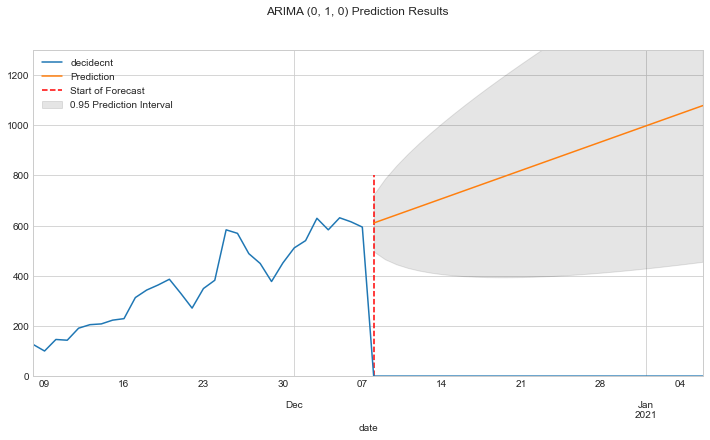

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
data_including_after2weeks.plot(ax=ax);
ax.vlines('2020-12-08', 0, 800, linestyle='--', color='r', label='Start of Forecast');
plt.ylim(0,1300)
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order} Prediction Results')
plt.savefig('./Forecast Corona Infection Status2(ARIMA).png')
plt.show()